<a href="https://colab.research.google.com/github/camlab-bioml/Astir-Vignette/blob/main/astir_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Astir
### A cell type assignment algorithm for single cell multiplexed imaging and proteomic data.

This is a reproducible notebook with some sample data for you to explore Astir's capability.

In [1]:
# # Install required packages
# !pip install astir
# !pip install pyyaml
# !pip install scanpy
# !pip install MulticoreTSNE
# !pip install wget

  Using cached https://files.pythonhosted.org/packages/2d/e8/2afa896fa4eebfa1d0d0ba2673fddac45582ec0f06b2bdda88108ced5425/MulticoreTSNE-0.1.tar.gz
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68517 sha256=802ea4580b00e60d43ba200a513412493fb67378c40c0c701af2de88e706b154
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=6177bb54c9d802194391c158f539613091c0b2936b544767de7363a53f346ee7
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Load some data
First we load some sample IMC data. These data are 50k cells from the Jackson et al. 2020 Nature publication.


As shown below, this is an AnnData object with 50,000 cells and in this case 38 total measured markers.

In [3]:
import anndata
import wget 
wget.download("https://github.com/camlab-bioml/Astir-Vignette/blob/main/basel_22k_subset.h5ad?raw=true", "basel_22k_subset.h5ad")

basel = anndata.read_h5ad("basel_22k_subset.h5ad")
basel

AnnData object with n_obs × n_vars = 22717 × 38
    obs: 'cell_id', 'batch'

## Creating an Astir object
Astir can take single cell expression data as AnnData or loom files with the `from_anndata_yaml` and `from_loompy_yaml` functions. Here we will use the AnnData version.





In [4]:
from astir.data import from_anndata_yaml

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Next, we need to convert the AnnData object into an Astir object. This also requires a list of marker files for each cell type of interest. 

The marker file should be a yaml file listing the markers that are expected to be overexpressed in each cell type as shown below:

In [5]:
import yaml

wget.download("https://raw.githubusercontent.com/camlab-bioml/Astir-Vignette/main/jackson-2020-markers-v4.yml", "jackson-2020-markers-v4.yml")

# Read in yaml file for illustration purposes
with open(r'jackson-2020-markers-v4.yml') as file:
  cell_types = yaml.load(file)

  print(cell_types['cell_types'])

{'Stromal': ['Vimentin', 'Fibronectin', 'SMA'], 'B cells': ['CD45', 'CD20'], 'T cells': ['CD45', 'CD3'], 'Epithelial (basal)': ['E-Cadherin', 'pan Cytokeratin', 'Cytokeratin 5', 'Cytokeratin 14'], 'Epithelial (other)': ['E-Cadherin', 'pan Cytokeratin'], 'Epithelial (luminal)': ['E-Cadherin', 'pan Cytokeratin', 'Cytokeratin 7', 'Cytokeratin 8/18', 'Cytokeratin 19'], 'Macrophage': ['CD45', 'CD68'], 'Endothelial': ['vWF', 'Vimentin']}


In [6]:
ast = from_anndata_yaml("basel_22k_subset.h5ad", "jackson-2020-markers-v4.yml", create_design_mat=True)
ast

## Training the model

Astir takes the following as input:


*   Batch size
*   Maximum number of epochs
*   A learning rate
*   An initial set of epochs




In [7]:
# Create batch size proportional to the number of cells
N = ast.get_type_dataset().get_exprs_df().shape[0]
batch_size = int(N/100)

# Number of training epochs
max_epochs = 1000

# Set learning rate
learning_rate = 2e-3

# Set initial epochs
initial_epochs = 3

To assign cell types simply call `fit_type` as follows.

In [8]:
ast.fit_type(max_epochs = max_epochs,
             batch_size = batch_size,
             learning_rate = learning_rate,
             n_init_epochs = initial_epochs)

training restart (final):   2%|▏         | 24/1000 [ 1.14s/epochs, current loss: -413120.1]


Importantly, Astir automatically creates a design matrix based on on additional covariates in the data such as batches. This is done using additional columns already present in the input data. In the example data of this vignette we have included a 'batch' column for the purposes of illustration.

We can get the cell type assignments in one of two ways:
1. Using `get_celltypes()`: this returns the most likely cell type or classifies a cell as unknown if no cell type has a probability above 0.7. (This threshold can be altered by the user with the threshold argument)
2. Using `get_celltype_probabilities()`: this returns the probabilty of each cell being assigned to any given cell type.

In [10]:
ast.get_celltypes().value_counts()

cell_type           
Stromal                 6410
Epithelial (luminal)    4698
Unknown                 4438
Other                   3108
Epithelial (other)      1643
Epithelial (basal)      1321
Macrophage               416
Endothelial              336
T cells                  270
B cells                   77
dtype: int64

In [11]:
ast.get_celltype_probabilities()

,Stromal,B cells,T cells,Epithelial (basal),Epithelial (other),Epithelial (luminal),Macrophage,Endothelial,Other
BaselTMA_SP43_173_X2Y8_1,0.647487,1.691061e-10,3.897103e-09,8.107791e-11,6.808052e-05,9.476300e-14,1.469026e-12,6.424200e-12,0.352445
BaselTMA_SP43_173_X2Y8_2,0.489101,1.294967e-09,4.803416e-07,1.219093e-08,6.716800e-04,4.135999e-12,2.960445e-10,2.642582e-02,0.483801
BaselTMA_SP43_173_X2Y8_3,0.108694,1.234617e-09,5.643817e-06,3.466964e-08,3.896031e-03,1.536765e-11,7.877039e-11,2.649017e-06,0.887402
BaselTMA_SP43_173_X2Y8_4,0.000138,2.139473e-12,1.645151e-10,1.704013e-11,3.231967e-08,8.936237e-15,3.851995e-15,9.998606e-01,0.000002
BaselTMA_SP43_173_X2Y8_5,0.047047,6.016889e-09,5.525472e-09,1.471456e-08,4.153400e-03,6.705593e-12,1.579849e-11,9.938507e-10,0.948800
...,...,...,...,...,...,...,...,...,...
BaselTMA_SP41_247_X13Y6_3683,0.014022,5.153947e-08,2.567271e-06,2.276985e-06,5.088522e-01,1.241388e-06,2.855280e-08,8.212348e-10,0.477119
BaselTMA_SP41_247_X13Y6_3684,0.999626,9.054548e-10,5.328781e-07,1.050336e-06,2.607842e-05,4.646511e-09,6.966831e-08,1.145917e-07,0.000346
BaselTMA_SP41_247_X13Y6_3685,0.989786,7.792933e-11,2.741676e-09,3.368553e-07,1.838706e-04,2.523045e-11,7.845248e-12,1.763245e-09,0.010030
BaselTMA_SP41_247_X13Y6_3686,0.059159,3.365031e-10,1.985898e-08,1.897388e-08,6.776061e-03,3.467217e-11,1.849253e-09,3.173700e-09,0.934065


## Post-fit diagnostics

As a sanity check for the user, Astir also outputs a set of post-fit diagnostics. These ensure that all cell types express their marker proteins at significantly higher levels that other cells.


In [12]:
ast.diagnostics_celltype()

,feature,should be expressed higher in,than,mean cell type 1,mean cell type 2,p-value,note
0,Vimentin,Stromal,Macrophage,0.515826,0.868201,1.808988e-36,None
1,CD45,B cells,Stromal,0.044866,0.042137,4.075282e-01,None
2,CD45,B cells,Epithelial (basal),0.044866,0.060091,1.009547e-04,None
3,CD3,T cells,Epithelial (basal),0.021331,0.036096,6.945841e-09,None
4,pan Cytokeratin,Epithelial (basal),B cells,0.673174,0.701355,5.260045e-01,None
5,pan Cytokeratin,Epithelial (basal),T cells,0.673174,0.781873,1.221683e-04,None
6,Cytokeratin 7,Epithelial (luminal),Epithelial (basal),0.046997,0.048900,4.041042e-01,None
7,Vimentin,Endothelial,Macrophage,0.845815,0.868201,6.002069e-01,None


## Analyzing our data

Now that we have assigned cell types to all cells, we can do some basic analysis.

Let us start with a t-SNE plot coloured by cell type. (This may take a while because it has to run t-SNE first).

In [13]:
import scanpy
scanpy.tl.tsne(basel, n_pcs = 50)

In [14]:
basel.obs["cell_type"] = ast.get_celltypes(threshold=0.5)['cell_type']

In [15]:
from itertools import chain
m_list = [x for x in cell_types['cell_types'].values()]
markers = list(chain.from_iterable(m_list))

markers = list(set(markers))

... storing 'cell_type' as categorical


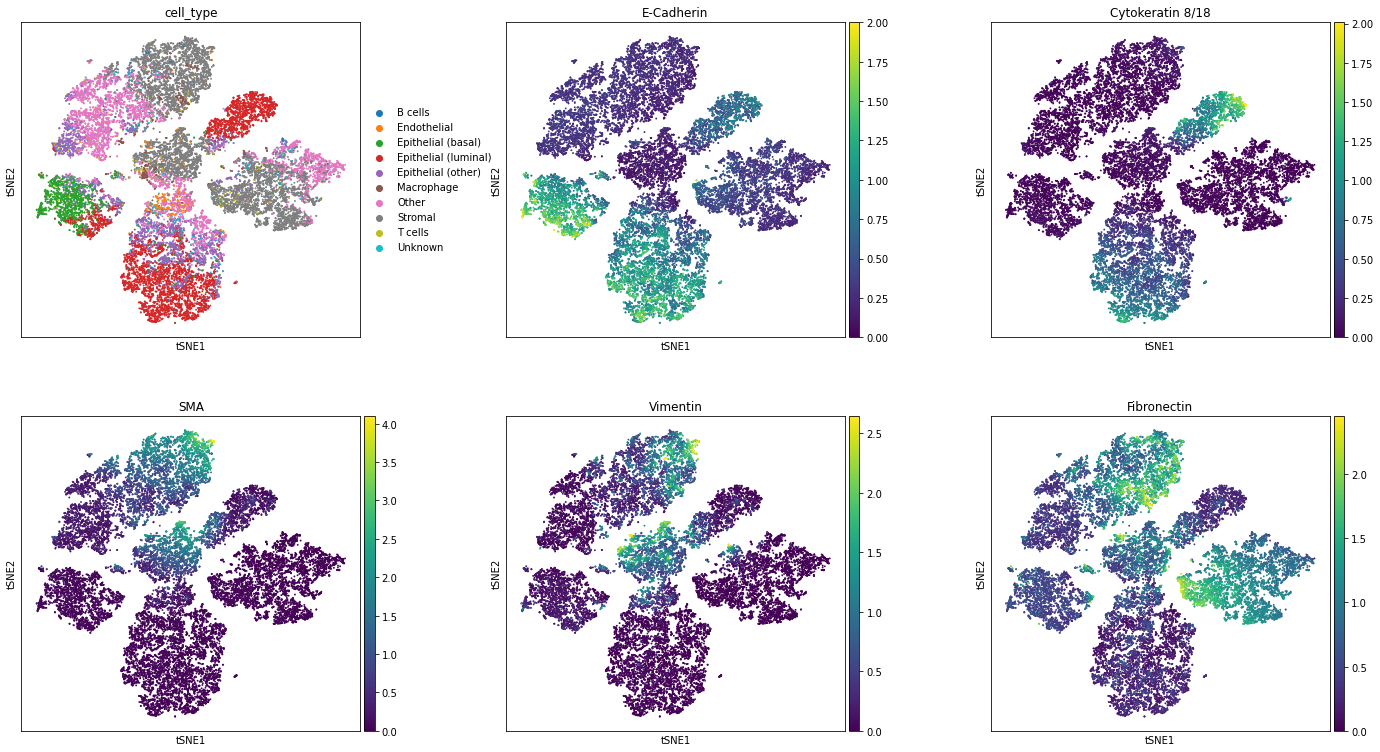

In [16]:
# color by markers
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (6, 6)}):
  scanpy.pl.tsne(basel, color = ['cell_type', 'E-Cadherin', 'Cytokeratin 8/18', 'SMA', 'Vimentin', 'Fibronectin'], size = 14, ncols = 3, wspace = 0.3)

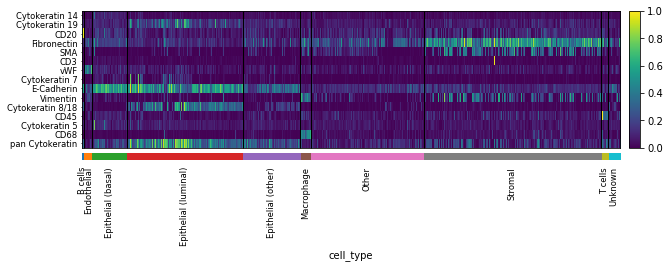

In [17]:
scanpy.pl.heatmap(basel, markers, groupby='cell_type', swap_axes=True, standard_scale='var')